In [1]:
train_dir= '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_dir= '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D,GlobalAveragePooling2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Dense
from keras.applications import InceptionV3,DenseNet201,VGG16,VGG19,Xception,ResNetRS420,DenseNet121
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_datagen= ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.2)

val_datagen= ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [4]:
train_generator= train_datagen.flow_from_directory(train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=100,
    shuffle=True,
    subset= 'training')
val_generator= val_datagen.flow_from_directory(train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=100,
    shuffle=True,
    subset= 'validation')

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.


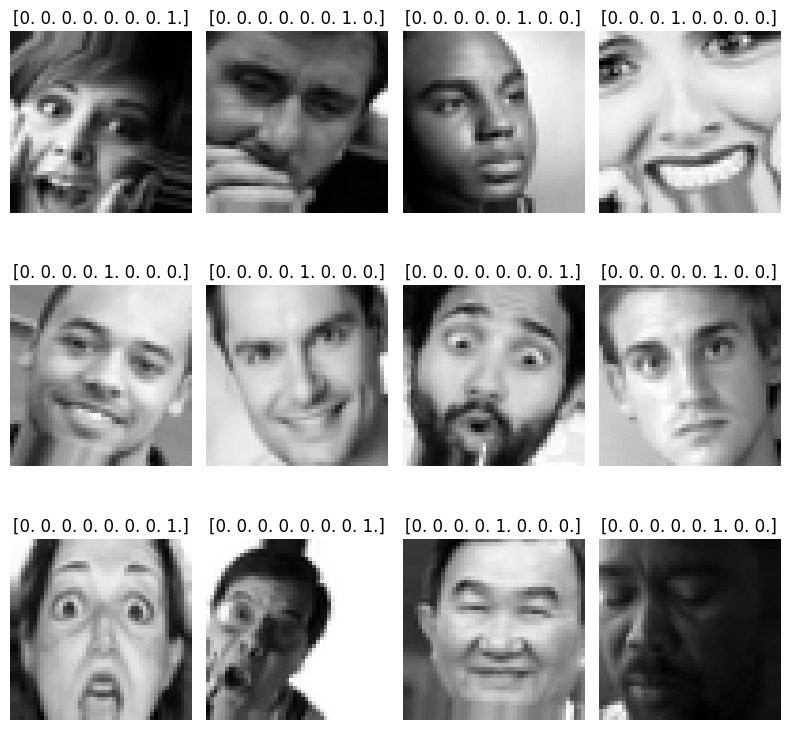

In [5]:
batch_images, batch_labels = train_generator.next()
plt.figure(figsize=(8,8))
for i in range (12):
    plt.subplot(3,4,i+1)
    plt.imshow(batch_images[i],cmap='gray') 
    plt.title(batch_labels[i])
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [6]:
# base_model= DenseNet201(include_top=False, weights='imagenet', input_shape=(48, 48, 1))


In [7]:
# Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False


In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))



model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

In [10]:
# lr_schedule= optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,
#                                                  decay_steps=1000,
#                                                  decay_rate=0.5)

# model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),loss= 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
# history=model.fit(train_generator,epochs=30,steps_per_epoch=50,verbose=1,validation_data=val_generator)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint_callback]
)

Epoch 1/50


2023-12-30 16:49:23.888941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 1.8626 - accuracy: 0.3054
Epoch 1: val_accuracy improved from -inf to 0.36324, saving model to model_weights.h5
100/100 [==============================] - 62s 483ms/step - loss: 1.8626 - accuracy: 0.3054 - val_loss: 1.6360 - val_accuracy: 0.3632
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.5527 - accuracy: 0.3927
Epoch 2: val_accuracy did not improve from 0.36324
100/100 [==============================] - 28s 283ms/step - loss: 1.5527 - accuracy: 0.3927 - val_loss: 1.6083 - val_accuracy: 0.3632
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 1.4495 - accuracy: 0.4678
Epoch 3: val_accuracy did not improve from 0.36324
100/100 [==============================] - 25s 251ms/step - loss: 1.4495 - accuracy: 0.4678 - val_loss: 1.5951 - val_accuracy: 0.3632
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 1.3299 - accuracy: 0.5282
Epoch 4: val_accuracy improved from 0

In [14]:
test_datagen= ImageDataGenerator(rescale=1./255)

test_generator= test_datagen.flow_from_directory(test_dir, 
                                                 target_size=(48,48),
                                                 color_mode='grayscale',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True)

Found 7099 images belonging to 8 classes.


In [15]:
model.load_weights(filepath='/kaggle/working/model_weights.h5')
model.evaluate_generator(test_generator,verbose=1)

222/222 [==============================] - 19s 85ms/step - loss: 0.6509 - accuracy: 0.7773


[0.6508650183677673, 0.7772925496101379]

In [16]:
model.save('fer2013plus.h5')